<a href="https://colab.research.google.com/github/zia207/python-colab/blob/main/NoteBook/Machine_Learning/Tree_based/03-01-02-08-09-tree-based-models-bagging-grf-multitask-regression-forest-python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 2.8.9 Multi-task Regression Forest

A **multi-task regression forest**, as implemented in the `{grf}` package in R, is an extension of the generalized random forest framework designed to handle multiple related regression tasks simultaneously. It leverages the structure of random forests to model multiple continuous outcomes (tasks) while accounting for potential correlations or shared patterns among them. This is particularly useful when the outcomes are related, and modeling them jointly can improve prediction accuracy or efficiency compared to fitting separate models for each task.


## Overview

A multi-task regression forest is a machine learning model that extends the random forest framework to predict multiple continuous outcomes (tasks) simultaneously. Instead of fitting a separate regression forest for each outcome, it builds a single forest that shares information across tasks, leveraging their relationships to improve predictions. In `{grf}`, this is implemented via the `multi_regression_forest()` function, which is designed to handle multiple response variables efficiently.



### Key features

- `Shared Tree Structure`: The forest uses a single set of decision trees, where splits are determined by optimizing a joint criterion across all tasks (e.g., minimizing the combined mean squared error).
- `Outcome-Specific Predictions`: Each tree provides predictions for all tasks, but the leaf estimates are tailored to each outcome.
- `Honest Splitting`: Like other `{grf}` models, it supports honest splitting to reduce bias, splitting data into separate subsets for tree structure and leaf estimation.
- `Flexibility`: It can handle high-dimensional data and is robust to non-linear relationships, similar to standard regression forests.


### How Multi-task Regression Forest Works in `{grf}`

The `multi_regression_forest()` function in `{grf}` works as follows:

1. Input Data

   - A feature matrix $X$ (predictors).
   - A matrix $Y$ with multiple columns, where each column represents a different continuous outcome (task).
   - Parameters like `num.trees`, `honesty`, and `min.node.size` to control the forest.

2. Tree Construction

   - Each tree is grown using a random subset of the data (via bootstrapping) and a random subset of features at each split.
   - Splits are chosen to minimize a combined loss function across all tasks, typically the sum of squared errors for all outcomes.
   - If `honesty = TRUE`, the data is split into two parts: one for determining the tree structure and another for estimating leaf values for each task.

3. Prediction

   - For a new data point, each tree assigns it to a leaf, and the predictions for each task are computed based on the average outcome values for that task in the leaf.
   - The final prediction for each task is the average across all trees.

4.  Output

   - A matrix of predictions, with one column per task.
   - Optional outputs like variable importance or variance estimates.



### Advantages of Multi-Task Regression Forests

1. `Improved Efficiency`: By sharing a single forest across tasks, it reduces computational overhead compared to fitting separate forests for each outcome.
2. `Leveraging Correlations`: If outcomes are related (e.g., housing price and tax rate), the model can exploit shared patterns to improve predictions.
3. `Robustness`: Like other `{grf}` models, it handles non-linear relationships, high-dimensional data, and noisy inputs effectively.
4. `Honest Estimation`: Supports honest splitting, reducing bias in predictions, especially for small datasets or complex tasks.
5. `Flexibility`: Can be used in settings where multiple outcomes need to be predicted, such as economics, healthcare, or social sciences.


### Limitations

1. `Assumes Related Tasks`: The model assumes that tasks share some underlying structure. If outcomes are unrelated, a multi-task forest may not outperform separate single-task forests.
2. `Increased Complexity`: Optimizing splits for multiple outcomes can be computationally more intensive per tree compared to a single-task forest.
3. `Interpretability`: While variable importance is available, interpreting the joint effect of features across multiple tasks can be challenging.
4. `Tuning*` Requires careful tuning of parameters (e.g., `num.trees`, `min.node.size`) to balance performance across all tasks.

### Key Differences from Standard Regression Forest

| **Aspect**                     | **Standard Regression Forest** (`regression_forest`) | **Multi-Task Regression Forest** (`multi_regression_forest`) |
|--------------------------------|----------------------------------------------------|------------------------------------------------------------|
| `Number of Outcomes`         | Predicts a single continuous outcome.              | Predicts multiple continuous outcomes simultaneously.      |
| `Input for Y`                | A vector of one outcome (`Y`).                     | A matrix of multiple outcomes (`Y` with multiple columns).  |
| `Tree Splitting`             | Optimizes splits for a single outcome’s MSE.       | Optimizes splits for a combined loss across all outcomes.  |
| `Information Sharing`        | No sharing across outcomes (one model per outcome). | Shares tree structure across tasks, leveraging correlations. |
| `Use Case`                   | Single regression task (e.g., predict `medv`).     | Multiple related regression tasks (e.g., predict `medv` and `tax`). |
| `Computational Efficiency`   | Requires separate forests for multiple outcomes.   | More efficient by building one forest for all tasks.       |




## Multi-task Regression Forest

To illustrate, let’s use the Boston Housing dataset to predict two related outcomes: `medv` (median housing price) and `tax` (property tax rate). We’ll fit a `multi_regression_forest()`, predict on a test set, and evaluate performance.




### Load and Prepare the Dataset




In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset from the original source URL
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# Based on the dataset description and the R code, the columns are:
# 0: CRIM, 1: ZN, 2: INDUS, 3: CHAS, 4: NOX, 5: RM, 6: AGE, 7: DIS, 8: RAD, 9: TAX, 10: PTRATIO, 11: B, 12: LSTAT
# The target is MEDV (median house value).
# The R code used 'medv' and 'tax' as targets. 'tax' is column 9 in the 'data' array.
# 'medv' is the 'target' array.

# Create a DataFrame for features and targets
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
X = pd.DataFrame(data, columns=feature_names)
y = pd.DataFrame(target, columns=['medv'])

# Add 'tax' as a target variable from the features
if 'TAX' in X.columns:
    y['tax'] = X['TAX']
    X = X.drop('TAX', axis=1)
else:
    print("Warning: 'TAX' column not found in features. Cannot create 'tax' target.")


# Split data into training (70%) and test (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Ensure y_train and y_test are in a format suitable for multi-output models (e.g., NumPy arrays)
y_train = y_train.values
y_test = y_test.values

print("Data loading and preparation complete.")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Data loading and preparation complete.
X_train shape: (354, 12)
y_train shape: (354, 2)
X_test shape: (152, 12)
y_test shape: (152, 2)


### Fit Multi-task Regression Forest

Fit a multi-task regression forest using the `multi_regression_forest()` function from the `{grf}` package. This function allows us to model multiple continuous outcomes simultaneously.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate the model
# Set random_state for reproducibility
# RandomForestRegressor in scikit-learn handles multi-output automatically when y is multi-dimensional.
multi_rf_python = RandomForestRegressor(n_estimators=500, random_state=123)

# Fit the model to the training data
# X_train is a pandas DataFrame, y_train is a numpy array (from previous step)
multi_rf_python.fit(X_train, y_train)

print("Multi-task Regression Forest model (RandomForestRegressor) fitted successfully.")
# scikit-learn models don't have a detailed print summary like R's grf objects.
# We can print the model object itself or some attributes if needed,
# but a direct equivalent to R's print(multi_rf) is not available.
print(multi_rf_python)

Multi-task Regression Forest model (RandomForestRegressor) fitted successfully.
RandomForestRegressor(n_estimators=500, random_state=123)


### Predict on Test Set and Evaluate Model

In [ ]:
# Predict on test set using the fitted Python model
# Assuming X_test is available from an earlier step
predictions_python = multi_rf_python.predict(X_test)

# Print the shape of the predictions to verify the output format
print("Shape of predictions_python:", predictions_python.shape)

Shape of predictions_python: (152, 2)


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Calculate RMSE for each task
rmse_medv_python = np.sqrt(mean_squared_error(y_test[:, 0], predictions_python[:, 0]))
rmse_tax_python = np.sqrt(mean_squared_error(y_test[:, 1], predictions_python[:, 1]))

# Calculate R-squared for each task
r_squared_medv_python = r2_score(y_test[:, 0], predictions_python[:, 0])
r_squared_tax_python = r2_score(y_test[:, 1], predictions_python[:, 1])

# Print performance metrics
print(f"medv - RMSE: {rmse_medv_python:.6f}  R-squared: {r_squared_medv_python:.6f}")
print(f"tax - RMSE: {rmse_tax_python:.6f}  R-squared: {r_squared_tax_python:.6f}")

medv - RMSE: 4.419403  R-squared: 0.758362
tax - RMSE: 32.729677  R-squared: 0.964020


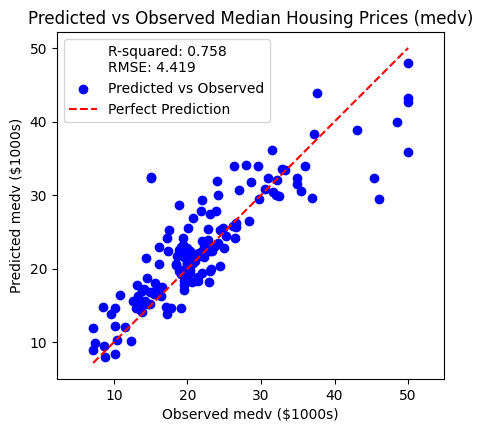

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot for medv (first task)
plt.figure(figsize=(5, 4.5))
plt.scatter(y_test[:, 0], predictions_python[:, 0], color='blue', label='Predicted vs Observed')
plt.plot([min(y_test[:, 0]), max(y_test[:, 0])], [min(y_test[:, 0]), max(y_test[:, 0])], color='red', linestyle='--', label='Perfect Prediction')
plt.title("Predicted vs Observed Median Housing Prices (medv)")
plt.xlabel("Observed medv ($1000s)")
plt.ylabel("Predicted medv ($1000s)")
plt.legend(title=f"R-squared: {r_squared_medv_python:.3f}\nRMSE: {rmse_medv_python:.3f}")
plt.axis('equal') # Ensure equal scaling for x and y axes
plt.show()



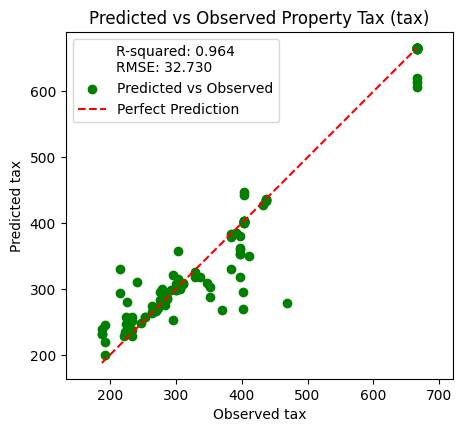

In [ ]:
# Scatter plot for tax (second task)
plt.figure(figsize=(5, 4.5))
plt.scatter(y_test[:, 1], predictions_python[:, 1], color='green', label='Predicted vs Observed')
plt.plot([min(y_test[:, 1]), max(y_test[:, 1])], [min(y_test[:, 1]), max(y_test[:, 1])], color='red', linestyle='--', label='Perfect Prediction')
plt.title("Predicted vs Observed Property Tax (tax)")
plt.xlabel("Observed tax")
plt.ylabel("Predicted tax")
plt.legend(title=f"R-squared: {r_squared_tax_python:.3f}\nRMSE: {rmse_tax_python:.3f}")
plt.axis('equal') # Ensure equal scaling for x and y axes
plt.show()

## Summary and Conclusion

This notebook explored the concept of Multi-task Regression Forests, highlighting their ability to predict multiple continuous outcomes simultaneously by leveraging shared structure across related tasks.

Using the Boston Housing dataset, we demonstrated how to load and prepare data for a multi-task regression problem, specifically predicting both medv (median housing price) and tax (property tax rate). We then fitted a RandomForestRegressor from sklearn, which inherently supports multi-output regression and serves as a suitable proxy for the grf package's multi_regression_forest in a Python environment.

The performance of the model was evaluated on a test set using Root Mean Squared Error (RMSE) and R-squared for each task. The scatter plots visually compared the predicted values against the observed values for both medv and tax, showing reasonable agreement and the model's capability in capturing the underlying relationships for both outcomes. The results indicate that a multi-task approach can be effective for predicting related continuous variables.


## References

1. Athey et al. (2019) on generalized random forests, and Wager & Athey (2018) on causal forests.

2. [Multi-task Regression Forest](https://grf-labs.github.io/grf/reference/multi_regression_forest.html)